In [45]:
#import modules
import pandas as pd
import numpy as np
import scipy as sp
from IPython import display

# common model algorithms
from sklearn import tree, svm, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process 
from xgboost import XGBClassifier
# common model helpers
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#import visualizations
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

import warnings
warnings.filterwarnings('ignore')

#utilities
import time
import re

#Configure inline and set style
%matplotlib inline
sns.set()

In [46]:
#import raw
data_raw = pd.read_csv('../train.csv')
data_val = pd.read_csv('../test.csv')
#make copy for wrangling
data1 = data_raw.copy(deep=True)
#put in one wrangling_set to wrangle both at once
wr_set = [data1, data_val]

In [47]:
print(data_raw.info())
data_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


891 entries except for Age, Cabin, and Embarked.

In [48]:
#How many missing values
print('Training Set nulls\n', data1.isnull().sum())
print('Testing Set nulls\n', data_val.isnull().sum())

Training Set nulls
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Testing Set nulls
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [49]:
data1.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Osen, Mr. Olaf Elon",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Deal with missing values

In [50]:
#Age- use median
# Embarked- use mode
# Fare- use median

for givenset in wr_set:
    givenset['Age'].fillna(value=givenset['Age'].median(), inplace=True)
    givenset['Embarked'].fillna(value=givenset['Embarked'].mode()[0], inplace=True)
    givenset['Fare'].fillna(value=givenset['Fare'].median(), inplace=True)
#Drop  PassengerId, Cabin, Ticket    
dropcols = ['PassengerId', 'Cabin', 'Ticket']
data1.drop(dropcols, axis=1, inplace=True)

In [51]:
print('Training Set nulls\n', data1.isnull().sum())
print('Testing Set nulls\n', data_val.isnull().sum())

Training Set nulls
 Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
Testing Set nulls
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


Bin Fare, Age.
Calculate family size

In [52]:
for givenset in wr_set:
    #FamilySize
    givenset['FamilySize'] = givenset['Parch']+givenset['SibSp']+1
    givenset.drop(['Parch','SibSp'], axis=1, inplace=True)
    #AgeBin
    givenset['AgeBin'] = pd.qcut(givenset['Age'], 4, labels=False)
    givenset.drop('Age', axis=1, inplace=True)
    #FareBin
    givenset['FareBin'] = pd.qcut(givenset['Fare'], 4, labels=False)
    givenset.drop('Fare', axis=1, inplace=True)   
    # Create Title feature
    givenset['Title'] = givenset['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [53]:
# Replace wrong designations
data1['Title'] = data1['Title'].replace({'Ms': 'Miss', 'Mme': 'Mrs', 'Mlle':'Miss'})

# Group uncommon designations as misc
stat_min = 10
title_names = data1['Title'].value_counts() < stat_min
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())

Mr        517
Miss      185
Mrs       126
Master     40
Misc       23
Name: Title, dtype: int64


In [54]:
data1.head()

,Survived,Pclass,Name,Sex,Embarked,FamilySize,AgeBin,FareBin,Title
0,0,3,"Braund, Mr. Owen Harris",male,S,2,0,0,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,C,2,3,3,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,S,1,1,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,S,2,2,3,Mrs
4,0,3,"Allen, Mr. William Henry",male,S,1,2,1,Mr


In [55]:
# encode categorical data
label = LabelEncoder()

for dataset in wr_set:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
# define y variable for target/outcome
Target = ['Survived']

# define x variables for feature selection
data1_x = ['Sex', 'Pclass', 'Embarked', 'Title', 'FamilySize']

# pretty name/values for charts
data1_x_calc = ['Sex', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize'] # coded for algo calc

data1_xy = Target + data1_x
print('Original X Y: ',data1_xy,'\n' )


# define x variables for original with bin features. Categorical coded numerically instead of in words.
data1_x_bin = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


# Establish dummy variables
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')

data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'FamilySize'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'FamilySize', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,2,0,1,0,0,1,0,0,0,1,0
1,1,2,1,0,1,0,0,0,0,0,0,1
2,3,1,1,0,0,0,1,0,0,1,0,0
3,1,2,1,0,0,0,1,0,0,0,0,1
4,3,1,0,1,0,0,1,0,0,0,1,0


In [77]:
# Split data into training and test set
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state=0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target], random_state=0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state=0)

print('data1 Shape:', data1.shape)
print('train1_x Shape:', train1_x.shape)
print('test1 Shape:', test1_x.shape)

train1_x_dummy.head()

data1 Shape: (891, 14)
train1_x Shape: (668, 5)
test1 Shape: (223, 5)


,Pclass,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
105,3,1,0,1,0,0,1,0,0,0,1,0
68,3,7,1,0,0,0,1,0,0,1,0,0
253,3,2,0,1,0,0,1,0,0,0,1,0
320,3,1,0,1,0,0,1,0,0,0,1,0
706,2,1,1,0,0,0,1,0,0,0,0,1


In [75]:
# Discrete variable correlation by survival using groupby pivot table
for x in data1_x:
    if data1[x].dtype != 'float64': #the sample code I ripped this from included this conditional, but I don't understand what it's purpose is and I appear to get the same results without it. Why screen out 'float64'?
        print('Survival Correlation by: ', x)
        print(train1[[x, Target[0]]].groupby(by=x, as_index=False).mean())
        print('-'*40,'\n')
        
# Using crosstabs
print(pd.crosstab(train1['Title'], train1[Target[0]]))

Survival Correlation by:  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------------------------------------- 

Survival Correlation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------------------------------------- 

Survival Correlation by:  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------------------------------------- 

Survival Correlation by:  Title
    Title  Survived
0  Master  0.575000
1    Misc  0.347826
2    Miss  0.702703
3      Mr  0.156673
4     Mrs  0.793651
---------------------------------------- 

Survival Correlation by:  FamilySize
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000
---------------------------------------- 

Survived    0    1
Title          

So I'm looking at the correlation between surviving and the attributes of Sex, PClass, Embarked_Code, Title_Code, FamilySize. 
The attribute 'female' has the highest correlation to survival with .742. The only correlation higher is the 'Mrs' title with .794, which is a subset of 'female'. 
Embarked_Code doesn't tell us much, just that 1 embarkation point had a better than 50 chance of survival. Does that code correlate with other statistics, like PClass? Did all the rich ladies get on at the same port? 
How are these features related to each other?
PClass is useful with .630 correlation to PClass = 1. Again, this may be showing the same underlying pattern as Embarked_Code. 
The value of a title is highly dependent on sex, so it's fair to say Title is generally a subset of it. It would be interesting to see how the titles in Misc could be reclassified as male/female and added in- is Jonkheer only a man's title? I don't think this would tell us much about predicting survival, though. Just curious about how the features relate to each other.
Now to look at visualizations. 

Text(0.5,1,'FamilySize Boxplot')

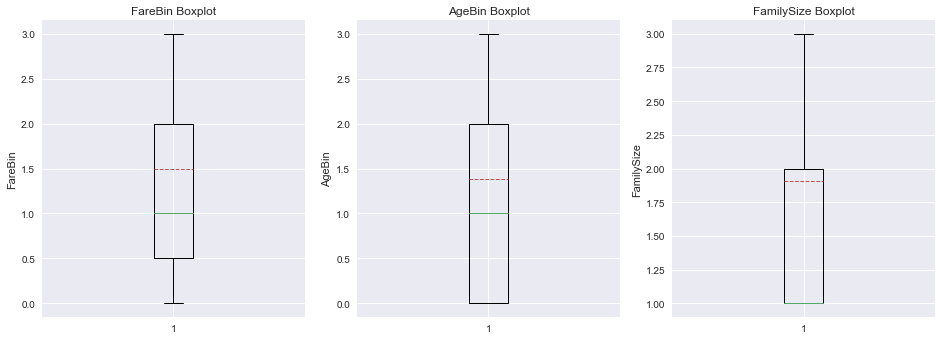

In [60]:
plt.figure(figsize=(16,12))
0
plt.subplot(231)
plt.boxplot(data1['FareBin'], sym='', meanline=True, showmeans=True);
plt.title('FareBin Boxplot')
# plt.xlabel('FareBin Boxplot')
plt.ylabel('FareBin')

plt.subplot(232)
plt.boxplot(data1['AgeBin'], sym='', meanline=True, showmeans=True);
plt.ylabel('AgeBin')
plt.title('AgeBin Boxplot')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], sym='', meanline=True, showmeans=True);
plt.ylabel('FamilySize')
plt.title('FamilySize Boxplot')


Build an ensemble model, see how to select features of models. 

In [61]:
# Machine Learning Algo Selection and Initialization
MLA = [
    # Ensemble methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    # Gaussian Process
    gaussian_process.GaussianProcessClassifier(),
    
    #General Linear Models
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    # Nearest Neighbour
    neighbors.KNeighborsClassifier(),
    
    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    # XGBoost
    XGBClassifier()
]

# Split dataset in cross-validation with sklearn shuffle split. This is an alternative to train_test_split
# run the model 10x, with a train/test split of 60/30, intentionally leaving out 10%
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=0)

# Create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns=MLA_columns)

# Create table to compare MLA predictions
MLA_predict = data1[Target]

# loop through MLA and save performance in the table
row_index = 0
for alg in MLA:
    
    # Set names and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # Score model with cross validation
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv=cv_split)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    
    # Find std, and if this is non-bias random sample, +/- 3 stdev from mean should statistically
    # capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    
    # Fit and predict for each MLA and save in df
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index += 1
    
# Print and sort table
MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.841573,0.825373,0.0441562,0.0414994
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.838764,0.825373,0.0497599,0.0498369
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.855993,0.824254,0.0476108,0.0203315
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.865918,0.81903,0.0480822,0.0678838
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.820037,0.816418,0.0570347,0.0718942
20,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.816292,0.806716,0.0792803,0.00179896
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.875468,0.801866,0.0584774,0.185923
8,RidgeClassifierCV,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': N...",0.800375,0.798507,0.0390991,0.00321188
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.895693,0.797388,0.0819614,0.0167201
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.800187,0.797015,0.0401115,0.00221276


In [81]:
#select SVC, fit, predict, submit
# test = data_val['Survived'].values
svm_model = svm.SVC(probability=True)
svm_model.fit(train1_x_dummy, train1_y_dummy)

# predictions = svm_model.predict()
#make predictions and store in 'Survived column of df_test
# Y_pred = clf.predict(test)
# df_test['Survived'] = Y_pred

# df_test[['PassengerId', 'Survived']].to_csv('predictions/1st_dtree.csv', index=False)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Can plot accuracy of each classifier


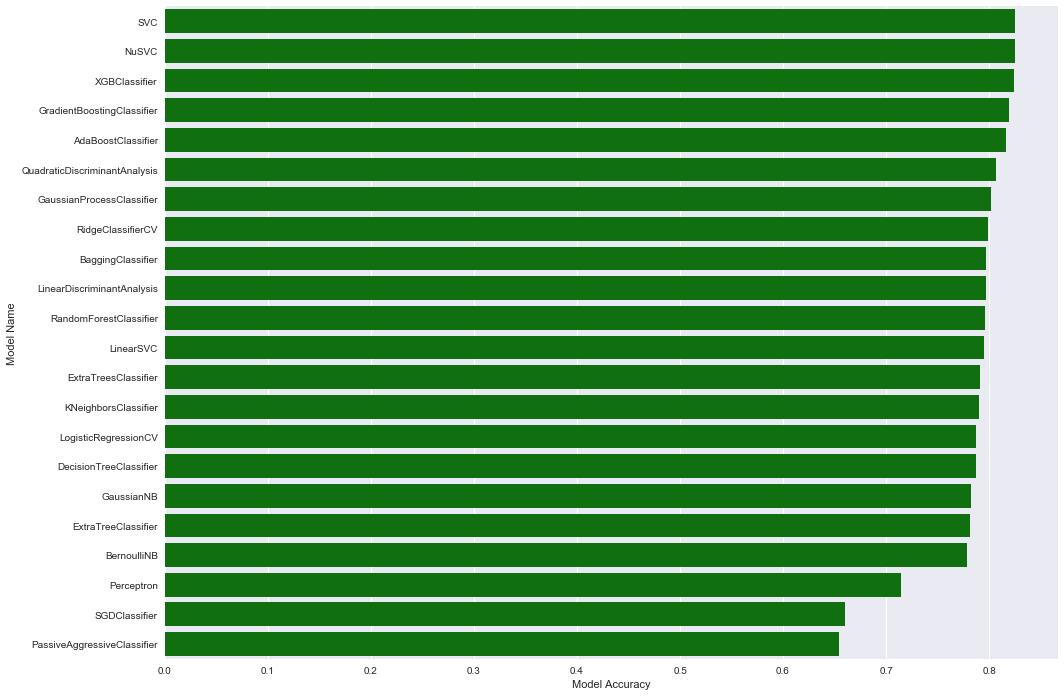

In [69]:
plt.figure(figsize=(16, 12))
sns.barplot(x='MLA Test Accuracy Mean', y='MLA Name', data=MLA_compare, color='g')
plt.xlabel('Model Accuracy')
plt.ylabel('Model Name');